# QRAM 



In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

### QRAM implementation in qiskit

In [81]:
def QRAM(no_of_address_qubits):
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = 2**a # no. of memory qubits
    bus = 1+a  # no. of bus qubits 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(1, "bus")
    cr = ClassicalRegister(bus, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
    ## adjust the address here
    
    qc.h(qr_a[0])
#     qc.x(qr_a[1])
#     qc.cx(qr_a[0],qr_a[1])
    #qc.h(qr_a[0])
    ## play with the memory element here if you want
    #qc.x(qr_m[0])
    qc.x(qr_m[1])
    ##
    qc.barrier()
    
### here we will start with the branching
    # there is X gate at the second qubit first
    
    qc.x(qr_r[1])
    # the first branching 
    qc.cx(qr_a[0],qr_r[0])
    qc.cx(qr_r[0],qr_r[1])
    qc.barrier()
    
    # further branchings 
    if a==1:
        ### measuring using measure one
        qc = qc.compose(meas_QRAM_order(a))

        ## finally measuring the bus
        for i in range(0,a):
            qc.measure(qr_a[i],cr[i])
        qc.measure(qr_bus, cr[a])
        return qc
    else:
        # no. of address bits = no. of rouitng iterations
        for i in range(2,a+1):
            for j in range(0,2**(i - 1)):
                 qc.ccx(qr_a[i-1], qr_r[j], qr_r[j + 2**(i-1)])
                 qc.cx(  qr_r[j + 2**(i-1)], qr_r[j])
            #qc.barrier()

### measuring using measure one
    qc = qc.compose(meas_QRAM_order(a))

## finally measuring the bus
    for i in range(0,a):
        qc.measure(qr_a[i],cr[i])
    qc.measure(qr_bus, cr[a])
    
    return qc

## Meas QRAM 

As the decoder part of the circuit activates different encoding qubits on the basis of different values that we provide. We have to make sure that the correct boolean value is corresponded to the correct value of the memory cell. For eg. on inputting |10> we should get memory cell 2

**Ordering** - One thing that is rather very important is the fact the ordering. At first I was going with the ordering that might seem obivous. The top most qubit($q_0$) comes on the lesftmost position we were putting these in the left most position. But cosidering QISKIT's ordering is different we will be switching this ordering. There are actually two functions now- 1. meas_QRAM_order and 2. meas_QRAM. The first one moves according the ordering offered by qiskit. Now the only difference between the two is that the first one appends 0's and 1's in the front whereas the second one does the same thing just at the end. 

In [80]:
def meas_QRAM_order(no_of_address_qubits):
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = 2**a # no. of memory qubits
    bus = 1+a # no. of bus qubits 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(1, "bus")
    cr = ClassicalRegister(bus, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
### measruing the correct qubit is the main things
    ## here we will make the array which has the ability to couple to the correct qubit it goes like(this is the 
    ## opposite convention of qiskit, qiskit does |q2q1q0> but this basis on q0q1q2)
    ##  1          10         100
    ##  0          00         000
    ##             11         110
    ##             01         010
    ##                        101 .... so on basically half the qubits gets concatinated with 0 and other half with 1

    div = np.array([1,0])
    new_div = ["" for x in range(2**a)]

        
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(0,div[j])
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(1,div[j])
        div = new_div[0:dim]
    
    # for the case of a = 1
    if a == 1:
        new_div = np.array([1,0])
        
        
    # as the original function uses strings we will need to convert shit to integers
    for i in range(0,len(new_div)):
            div[i] = int(new_div[i])
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job

    for i in range(0, 2**a  ):
        qc.ccx(qr_r[i], qr_m[int(div_decimal[i])], qr_bus)
        
        
### you can adjust th

    
    return qc

In [52]:
def meas_QRAM(no_of_address_qubits):
    a = no_of_address_qubits
    r = 2**a # no.of routing qubits
    m = 2**a # no. of memory qubits
    bus = 1+a # no. of bus qubits 
    
    qr_a = QuantumRegister(a, "a")
    qr_r = QuantumRegister(r, "r")
    qr_m  = QuantumRegister(m,  "m")
    qr_bus = QuantumRegister(1, "bus")
    cr = ClassicalRegister(bus, "readout")
    
    qc = QuantumCircuit(qr_a,qr_r,qr_m,qr_bus, cr)
    
### measruing the correct qubit is the main things
    ## here we will make the array which has the ability to couple to the correct qubit it goes like(this is the 
    ## opposite convention of qiskit, qiskit does |q2q1q0> but this basis on q0q1q2)
    ##  1          10         100
    ##  0          00         000
    ##             11         110
    ##             01         010
    ##                        101 .... so on basically half the qubits gets concatinated with 0 and other half with 1

    div = np.array([1,0])
    new_div = np.zeros(2**(a))
    
    for i in range(0,a-1): # here i controls the number of times this loop runs, each time we move one level ahead
        div = np.append(div,div)
        dim = len(div)
        for j in range(0,int(dim/2)):
            new_div[j] = numConcat(div[j],0)
        for j in range(int(dim/2),int(dim)):
            new_div[j] = numConcat(div[j],1)
        div = new_div[0:dim]
        

        
    # cnverting the array to decimal
    div_decimal = np.zeros(len(div))
    for i in range(0, len(div)):
        div_decimal[i]  = int(binaryToDecimal(div[i])) 
## here is the quantum circuit part of things which do the job

    for i in range(0, 2**a  ):
        qc.ccx(qr_r[i], qr_m[int(div_decimal[i])], qr_bus)
        
        
### you can adjust th

    
    return qc

In [53]:
## to functions that we will be using for concatination of "0" and "1" in front the numbers and the other one for addition for the conversion of the binary to decimal 
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1

### Verification of working to see whether our code works or not

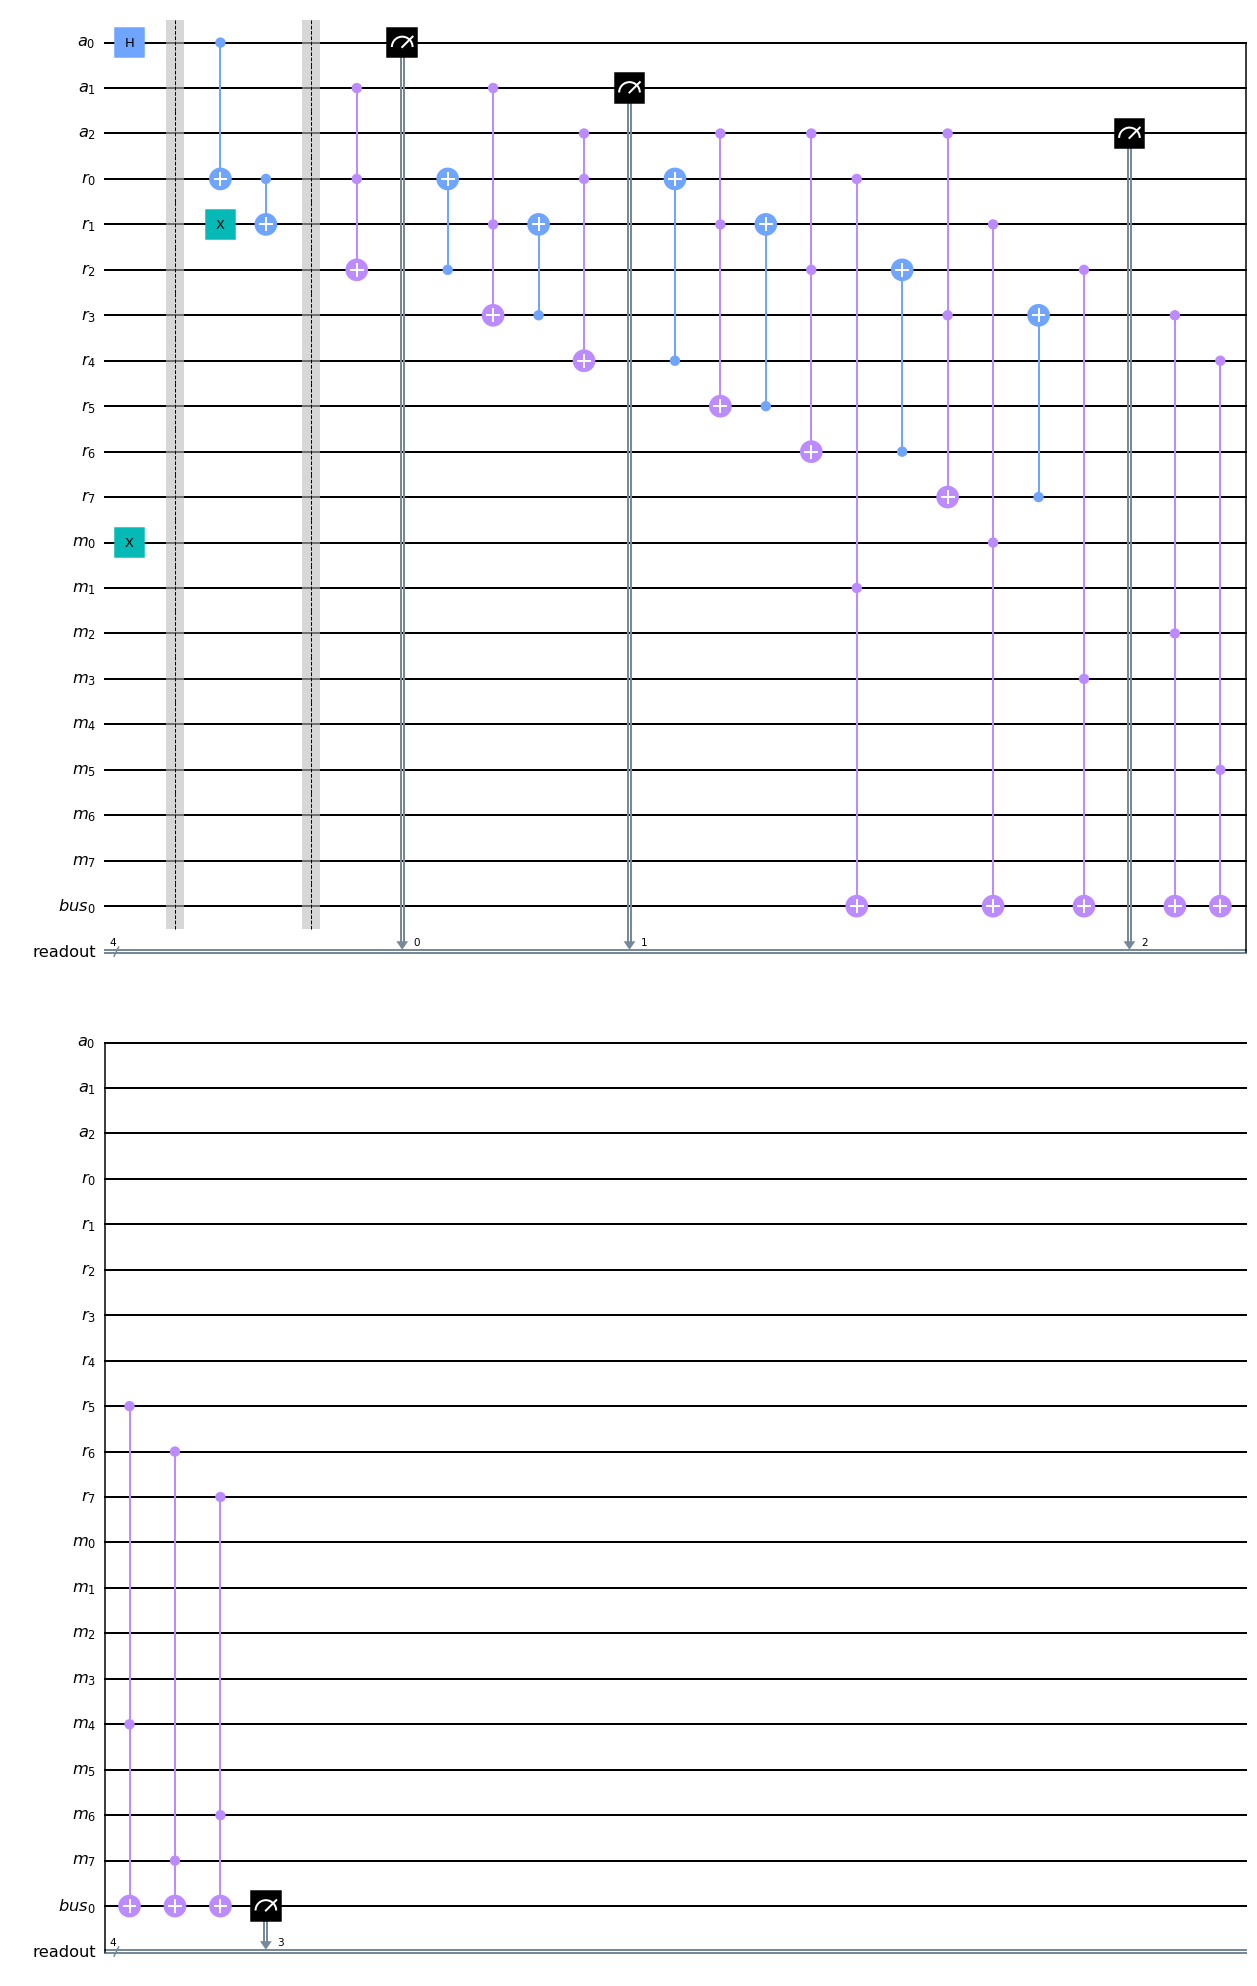

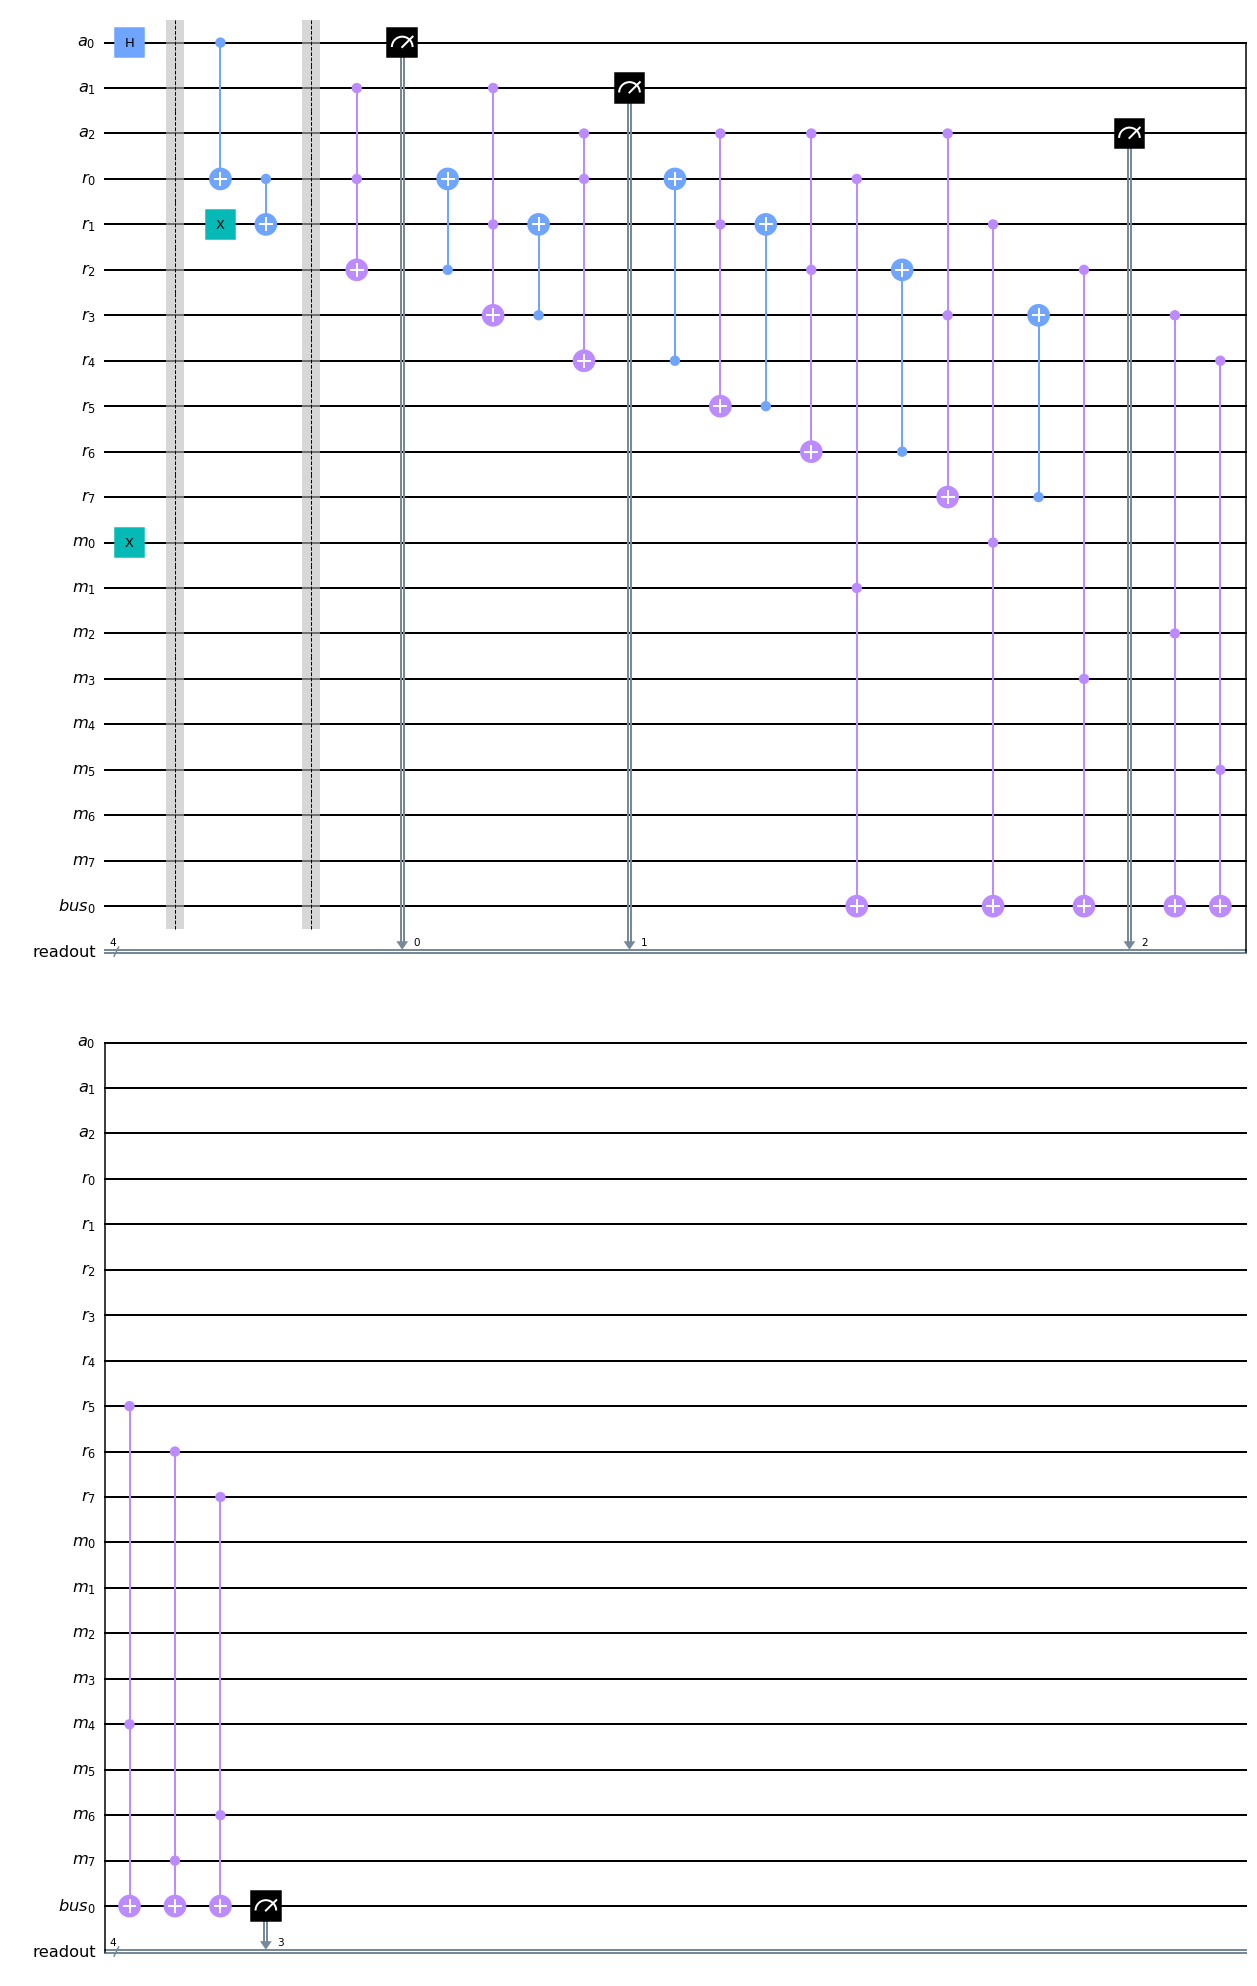

In [54]:
QRAM(3).draw('mpl')

## Querying Superpositions

Bucket Brigade Quantum RAM can hold only classical information but it can query a superposition of all these.The overall process can be written as 
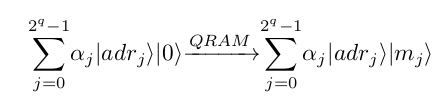
where $|adr_i>$ is the address of the memory cell and the $|m_i>$ is the classical bit stored in that memory cell. 

Earlier I was thinking that our circuit does not actually satisfy this equation because of the entanglement with all the encoding qubits. But it does and we can extract particular memory cells and produce any statee using this more easily. 

#### Step by step analysis 
Here we will be inputting the state ${|\psi>}$into QRAM(1)

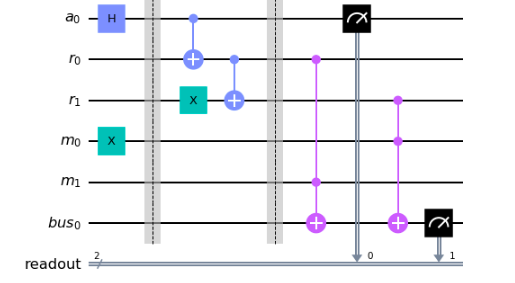
The state looks like
$$
|\psi> = |0> + |1>
$$

and this should look into the memory cells 0 and 1 and as we have stored '0' in memory cell 1 and '1' in memory cell 0. The final state, 
$$
|\phi> = |1>|0> + |0>|1>
$$
**Note** here the ordering is |memory>|adress> because of the ordering of qiskit and for later discussion the qubits are ordered as **$|bus_0 m_1 m_0 r_1 r_0 a_0>$**

After first hadamard gate, we get

$$
|0> + |1>
$$

cx between r_0 and a_0

$$
|00> + |11>
$$

the r_1 bit will flip if the r_0 is on 

$$
|100> + |011>
$$

now the memory bits are introducd and these are stuck and will not change

$$
|01100> + |01011>
$$

two ccx gates determine finally which qubit line is measured, first one is r_0 and m_1

$$
|(0)11(0)0> + |(0)10(1)1>
$$

and this copies whatever is there in m1 to bus

$$
|001100> + |0101011>
$$

Second one does a similar thing and we see that, r_1 and m_0 matters 

$$
|00(11)00> + |010(10)11>
$$

we get 

$$
|101100> + |0101011>
$$

now ignoring all the middle ones and focusing on $|bus_0 0 0 0 0 a_0>$. We get, 

$$
|10> + |01>
$$

That is what we should get.

### run this and verify 

In [61]:
qc = QRAM(1)

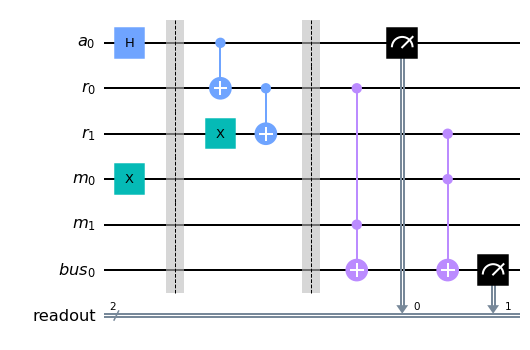

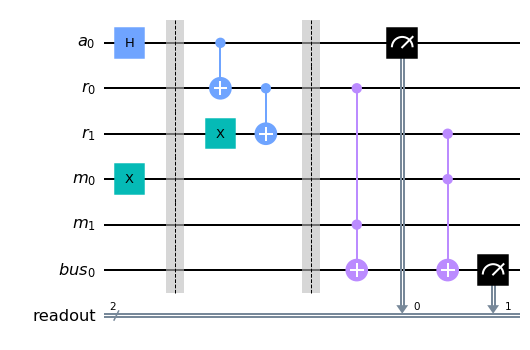

In [62]:
qc.draw('mpl')

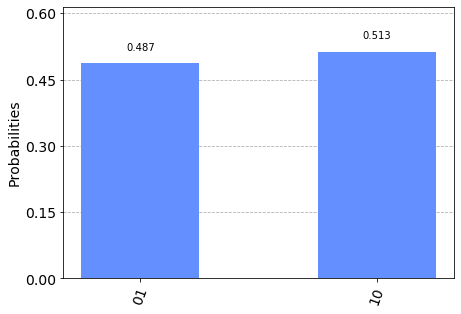

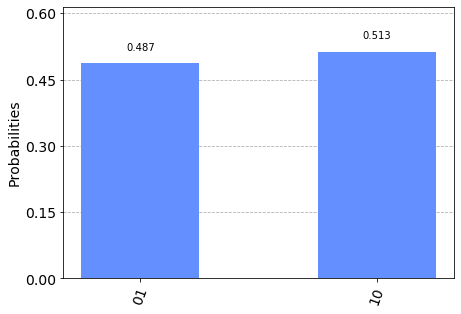

In [63]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend)
counts = job.result().get_counts()
plot_histogram(counts)

### Bigger try 
Let's try this for a bigger version. Store 1's in m_0 and m_1. and input state |01> + |10>. The output should be |1>|01> + |0>|10> 

In [68]:
qc_2 = QRAM(2)

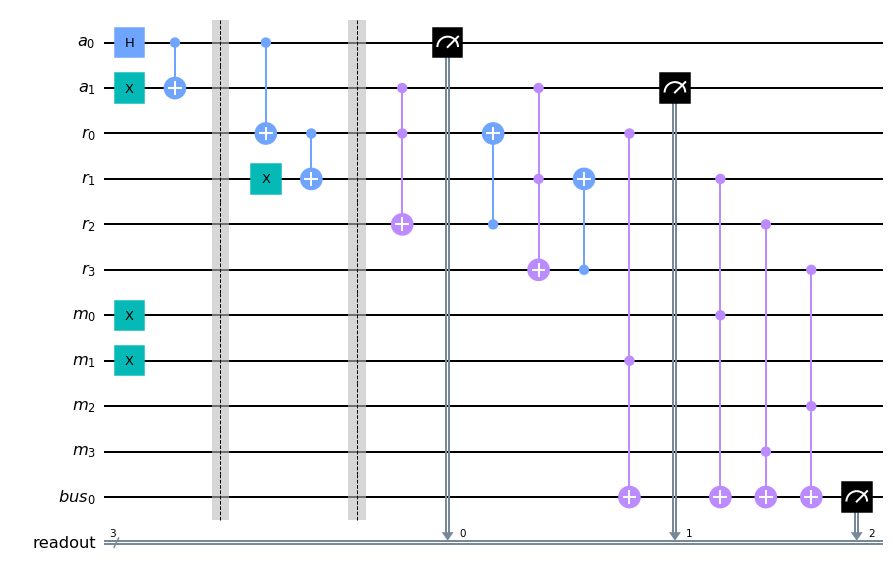

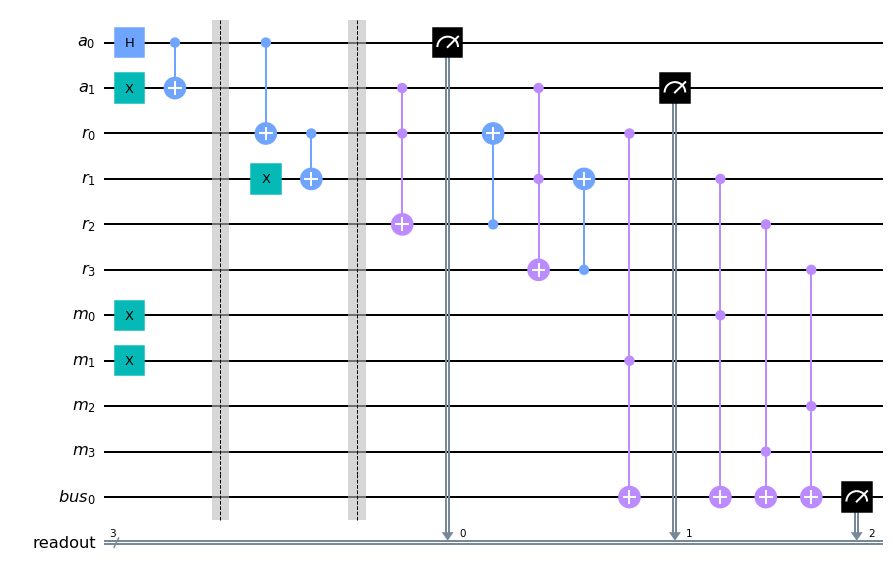

In [69]:
qc_2.draw('mpl')

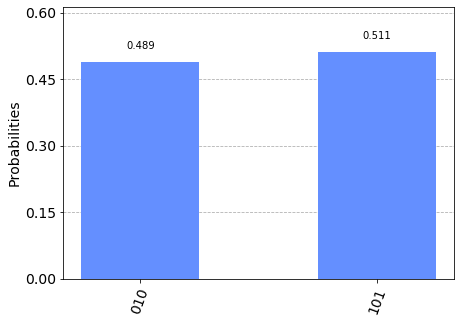

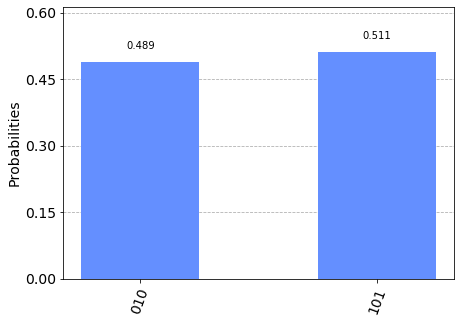

In [70]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc_2,backend)
counts = job.result().get_counts()
plot_histogram(counts)

### 3 address qubits

input a_0 as |0> + |1> and everything else as |0> and store '1' in the 1st memory cell. Now the output should be - |0>|000> + |1>|001>

In [85]:
qc_3 = QRAM(3)

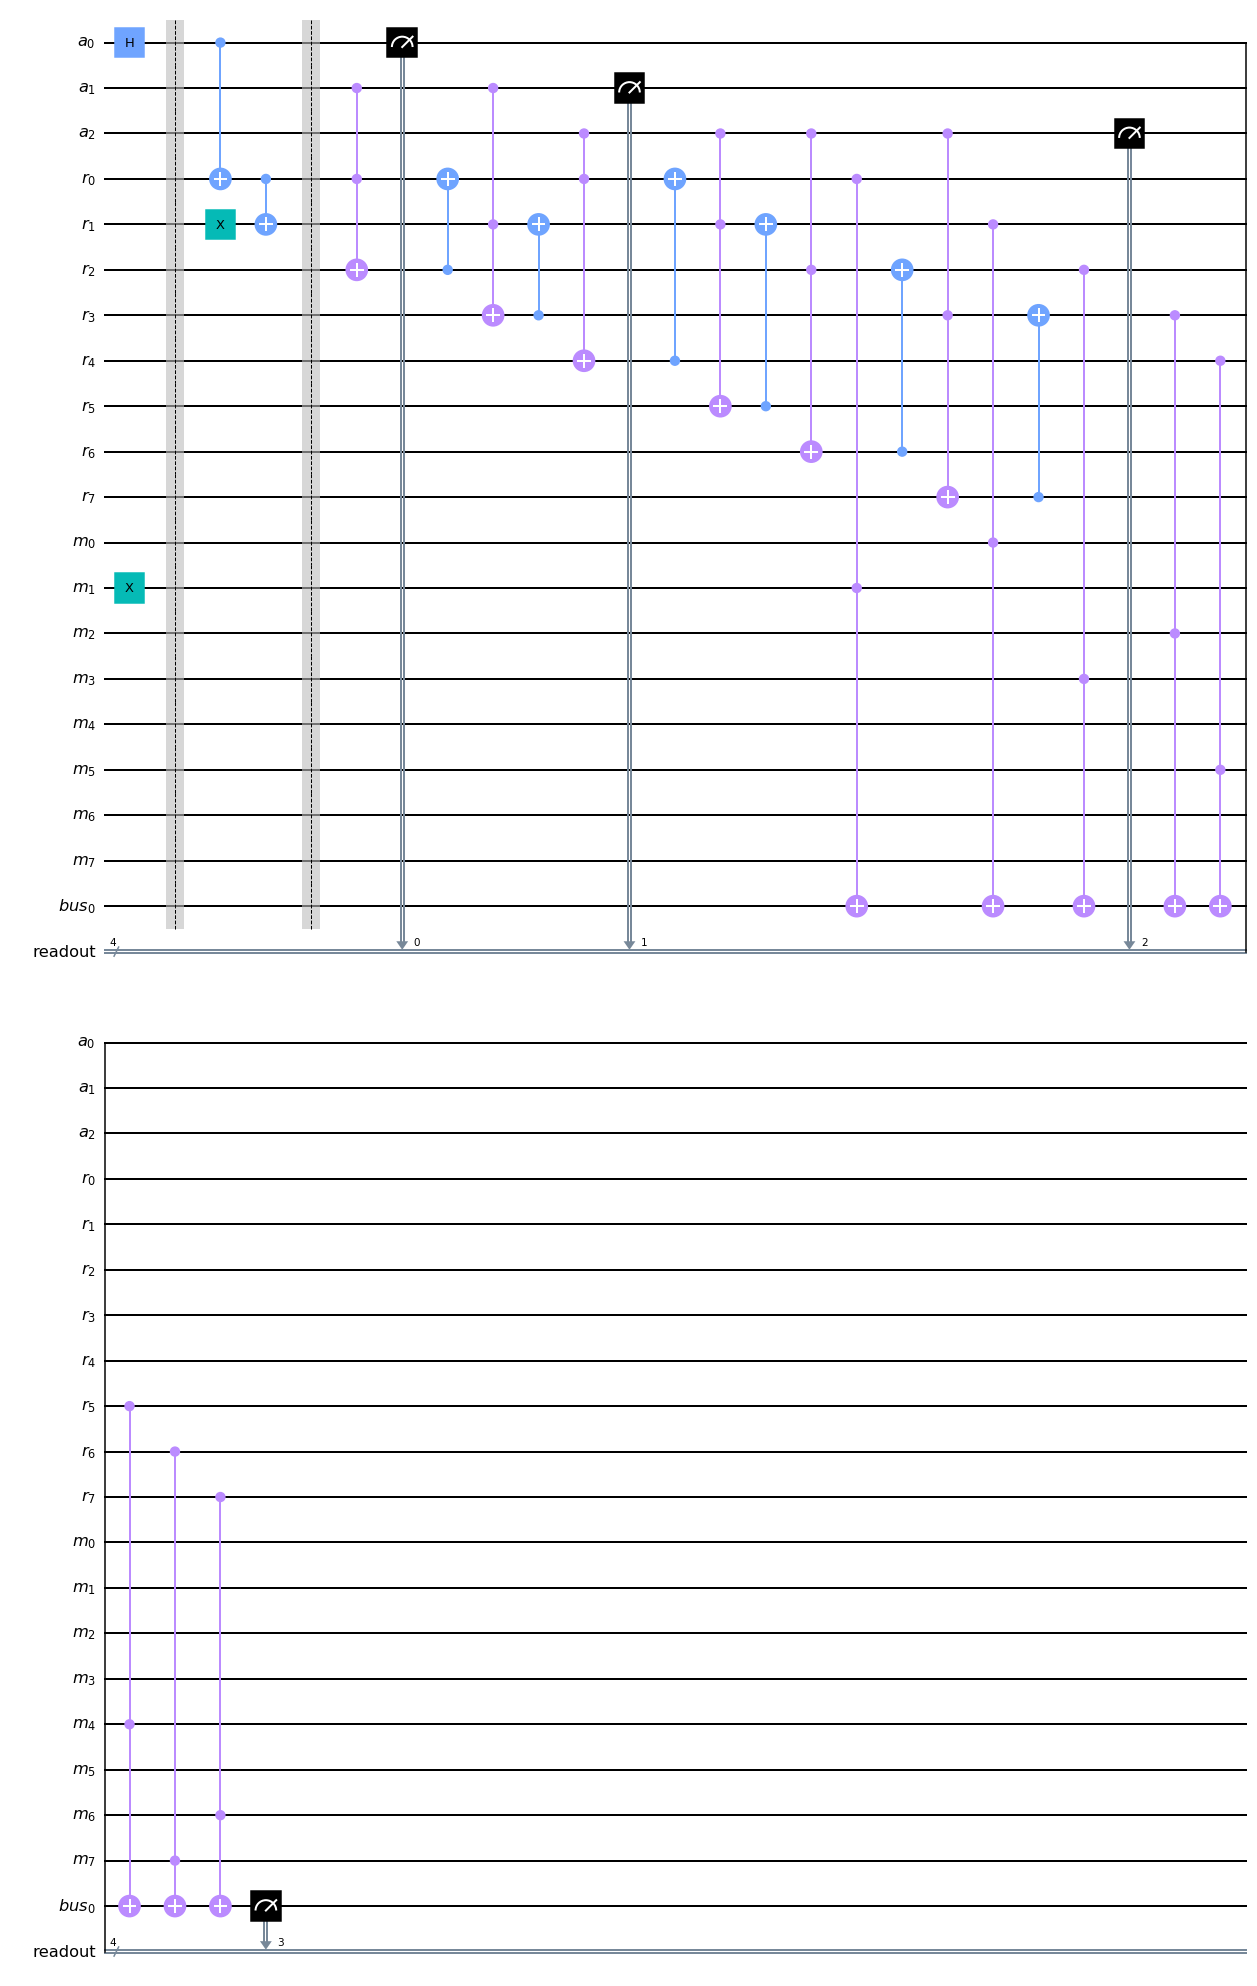

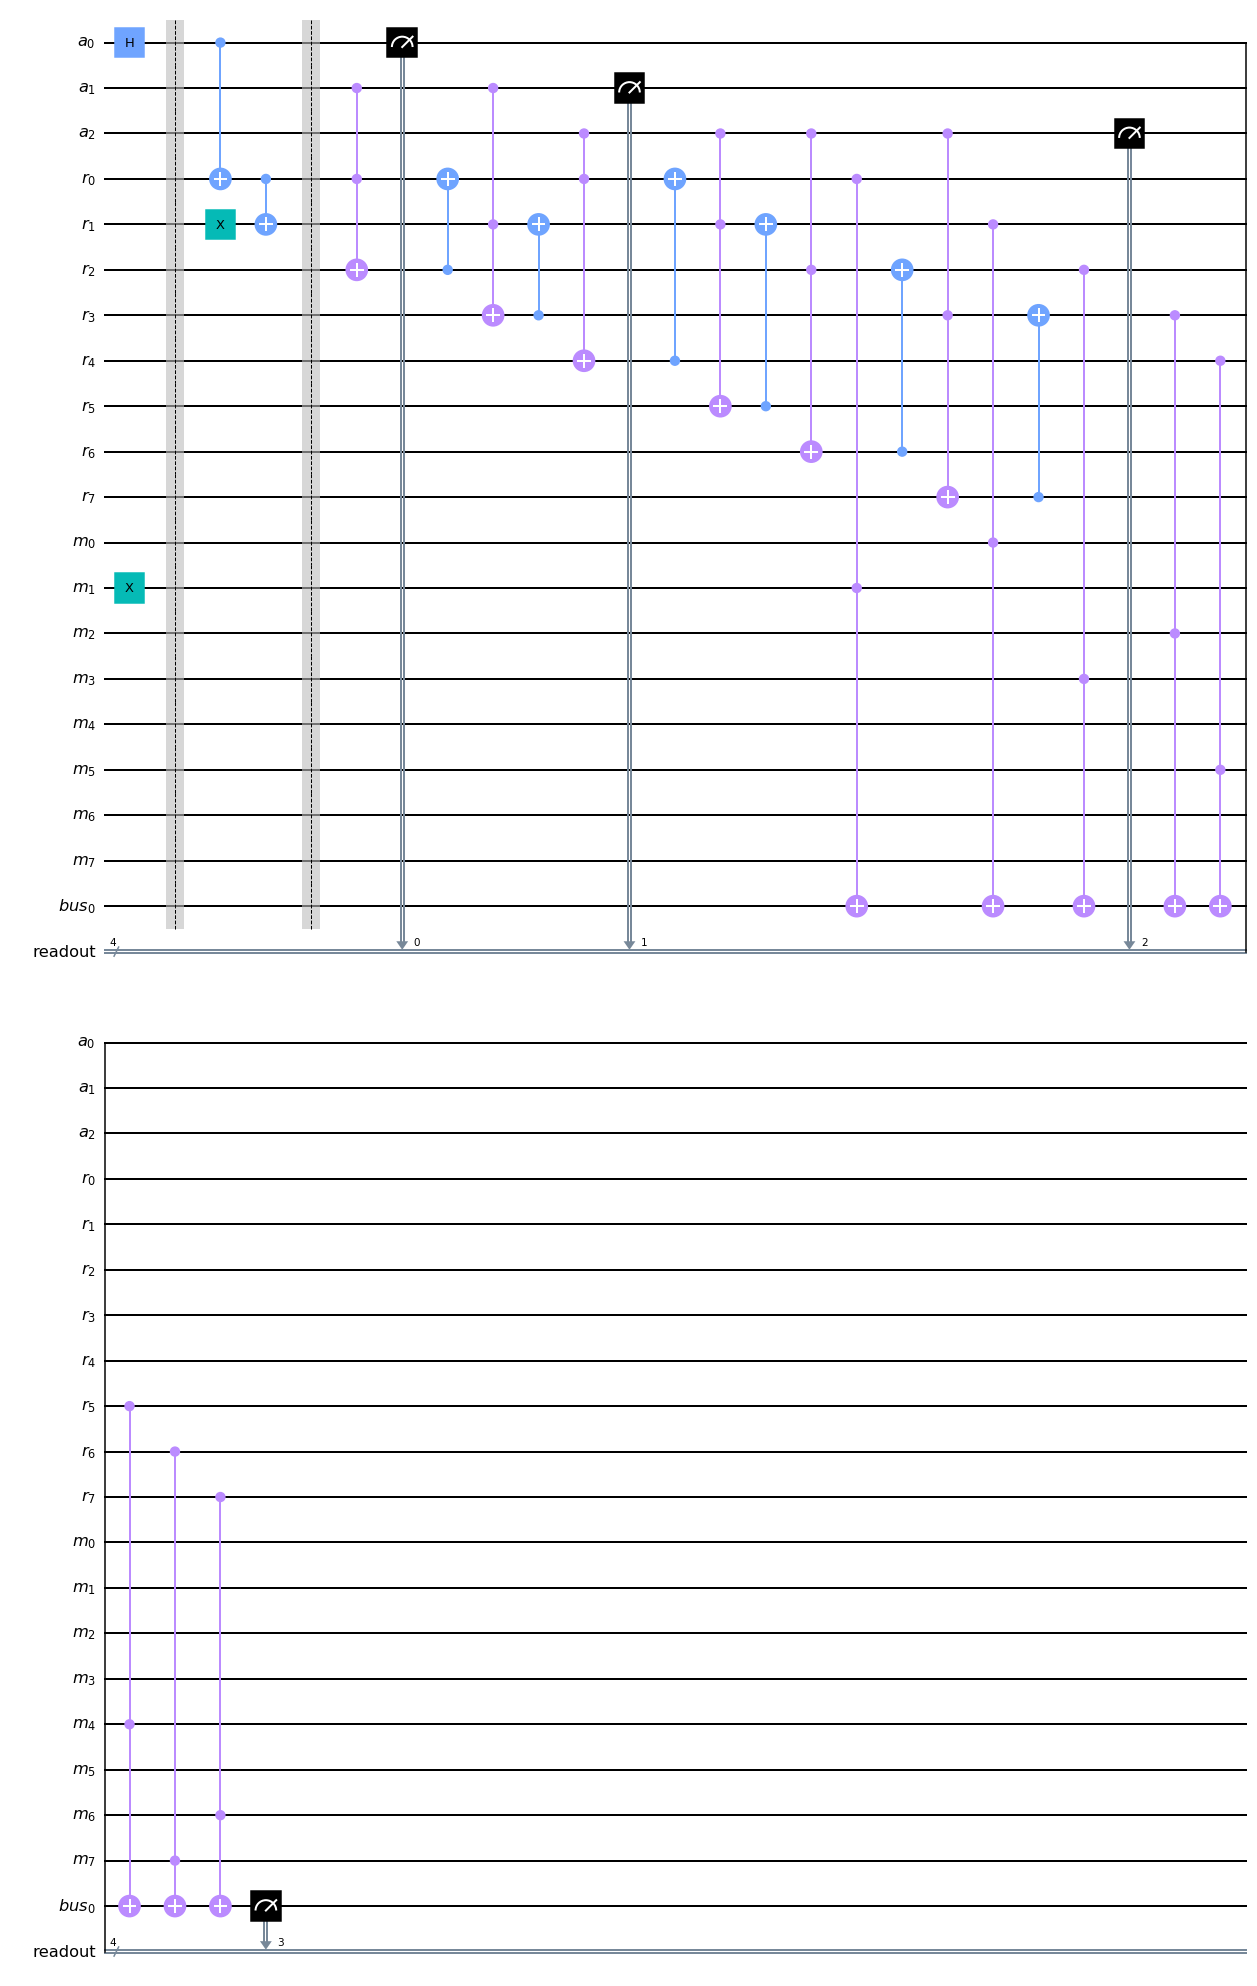

In [83]:
qc_3.draw('mpl')

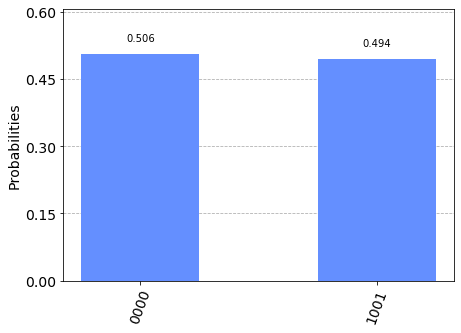

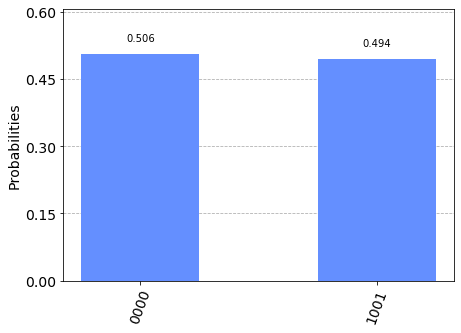

In [84]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc_3,backend)
counts = job.result().get_counts()
plot_histogram(counts)

That is exactly what we expected and hence our QRAM is working fine!!!!!

## Refrences 
1. [Quantum random access memory](https://arxiv.org/abs/0708.1879)
2. [On the robustness of bucket brigade quantum RAM](https://arxiv.org/abs/1502.03450)
3. [Parallelising the Queries in Bucket Brigade Quantum RAM](https://arxiv.org/abs/2002.09340)
4. [Quantum random access memory via quantum walk](https://iopscience.iop.org/article/10.1088/2058-9565/abf484)
5. [Fault-Tolerant Resource Estimation of Quantum Random-Access Memories](https://ieeexplore.ieee.org/document/8962352)
6. [IMPLEMENTING QRAM IN QISKIT WITH CODE(a blogpost)](https://quantumcomputinguk.org/tutorials/implementing-qram-in-qiskit-with-code)


## Space for some extra stuff

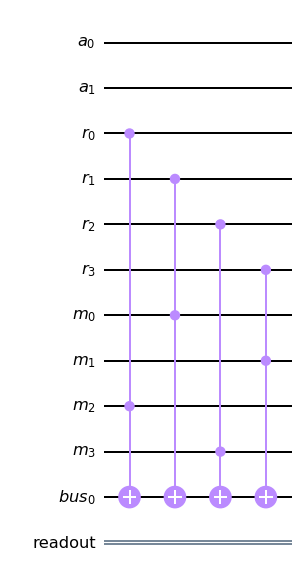

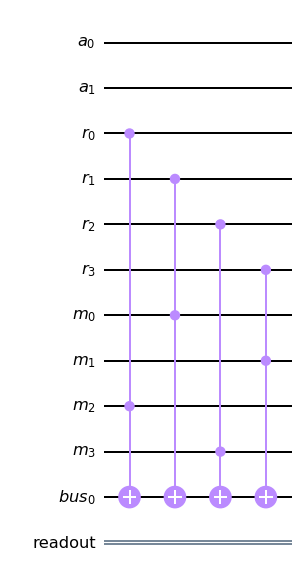

In [9]:
meas_QRAM(2).draw('mpl')

In [10]:
for i in range(2,4):
    print(i)

2
3


In [11]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)

In [12]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
state = job.result().get_statevector()
plot_bloch_multivector(state)

ValueError: Unknown projection '3d'

<Figure size 576x288 with 0 Axes>

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(qc, backend).result()
psi  = result.get_statevector(qc)